In [1]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import pickle

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

Links
- US vaccine tracker
    - https://www.mayoclinic.org/coronavirus-covid-19/vaccine-tracker/
    - https://usafacts.org/visualizations/covid-vaccine-tracker-states/
- Interactive world wide tracker
    - https://ourworldindata.org/covid-vaccinations
- **vaccine data - https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc
- **cases/deaths - https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
- **forecast - https://covid.cdc.gov/covid-data-tracker/#forecasting_weeklydeaths
- **hospitalizations - https://gis.cdc.gov/grasp/COVIDNet/COVID19_5.html
- **hopitalizations data - https://www.cdc.gov/coronavirus/2019-ncov/science/forecasting/hospitalizations-forecasts.html
- **the repository - https://github.com/reichlab/covid19-forecast-hub#ensemble-model

In [3]:
df = pd.read_csv('data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')

In [ ]:
df[df['Location'] == 'NJ'][['Date', 'Distributed', 'Dist_Per_100K',
                            'Administered', 'Admin_Per_100K', 'Administered_Dose1_Pop_Pct']]

In [4]:
fatal_df = pd.read_csv('data/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv')

In [5]:
fatal_df['submission_date'] = pd.to_datetime(fatal_df['submission_date'])

In [ ]:
fatal_df.columns

In [ ]:
fatal_df[fatal_df['state'] == 'NJ'].sort_values(by = 'submission_date')[['submission_date', 'new_case']]

In [6]:
nj_test_df = df[df['Location'] == 'NJ'][['Date', 'Distributed', 'Dist_Per_100K',
                            'Administered', 'Admin_Per_100K', 'Administered_Dose1_Pop_Pct']]
nj_test_df['Date'] = pd.to_datetime(nj_test_df['Date'])

nj_fatal_test_df = fatal_df[fatal_df['state'] == 'NJ'].sort_values(by = 'submission_date')[['submission_date', 'new_death']]
nj_fatal_test_df.rename(columns = {'submission_date': 'Date'}, inplace = True)

nj_fatal_test_df.drop(index = nj_fatal_test_df[nj_fatal_test_df['Date'] == '2021-07-05'].index[0], inplace = True)

nj_fatal_test_df['new_death'] = np.where(nj_fatal_test_df['new_death'] < 0, 3,
                                         np.where(nj_fatal_test_df['new_death'] == 190, 3,
                                                  nj_fatal_test_df['new_death']))

nj_test_df.set_index(keys = 'Date', drop = True, inplace = True)
nj_fatal_test_df.set_index(keys = 'Date', drop = True, inplace = True)
test_df = pd.concat([nj_test_df, nj_fatal_test_df], join = 'outer', axis = 1)
test_df = test_df.fillna(0)
#test_df = test_df.resample('W').mean()

In [ ]:
test_df.describe()

In [ ]:
seasonal_decompose(test_df['new_death'], model = 'additive').plot();

In [7]:
test_train = test_df.iloc[:len(test_df) - 10]
test_test = test_df.iloc[len(test_df) - 10:]

In [8]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [ ]:
parameter_results = pd.DataFrame(columns = ['order', 'seasonal_order', 'aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(test_train['new_death'],
                        exog = test_train[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']],
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            results = mod.fit()
            parameter_results = parameter_results.append({'order': param,
                                                          'seasonal_order': param_seasonal,
                                                          'aic': results.aic},
                                                         ignore_index = True)
            print(f'Tested {param}, {param_seasonal}.')
        except: 
            print('Oops!')
            continue

In [101]:
#pickle_out = open(".pickle/parameter_results.pickle","wb")
#pickle.dump(parameter_results, pickle_out)
#pickle_out.close()

In [9]:
infile = open(".pickle/parameter_results.pickle",'rb')
parameter_results = pickle.load(infile)
infile.close()

In [11]:
lowest_aic = parameter_results.sort_values('aic', ascending = True).head(1)

In [12]:
sari=SARIMAX(test_train['new_death'],
            exog = test_train[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']],
            order=lowest_aic['order'].values[0],
            seasonal_order=lowest_aic['seasonal_order'].values[0],
            enforce_stationarity=False,
            enforce_invertibility=False).fit()

In [13]:
sari_predict = sari.predict(dynamic = False,
#                            typ = 'levels',
                            exog = test_df[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']]
)

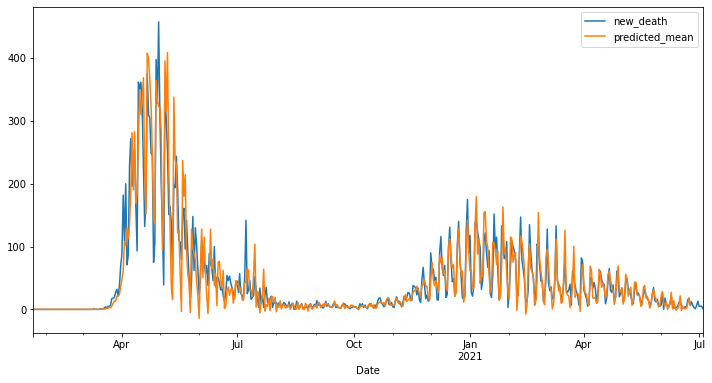

In [14]:
ax = test_df['new_death'].plot(legend=True,figsize=(12,6))
sari_predict.plot(legend=True)
ax.autoscale(axis='x', tight=True);

In [15]:
sari_test_predict = sari.predict(dynamic = len(test_train)-80,
                                 exog = test_df[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']]*.02
)

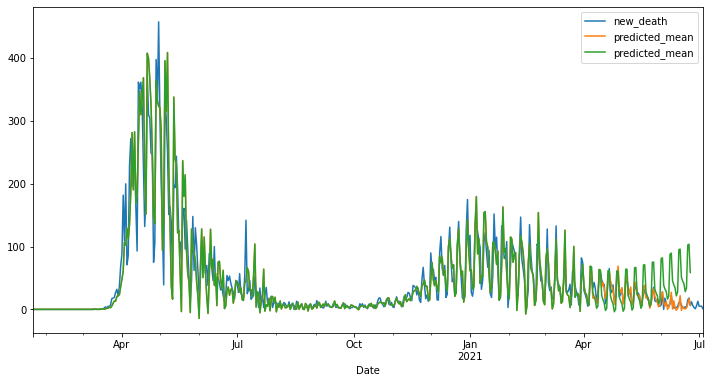

In [16]:
ax = test_df['new_death'].plot(legend=True,figsize=(12,6))
sari_predict.plot(legend=True)
sari_test_predict.plot(legend=True)
ax.autoscale(axis='x', tight=True);

In [18]:
test_df_week = test_df.resample('W').mean()

In [20]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

In [21]:
arima_parameter_results = pd.DataFrame(columns = ['order', 'seasonal_order', 'aic'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod=SARIMAX(test_df_week['new_death'],
                        exog = test_df_week[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']],
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            results = mod.fit()
            arima_parameter_results = arima_parameter_results.append({'order': param,
                                                          'seasonal_order': param_seasonal,
                                                          'aic': results.aic},
                                                         ignore_index = True)
            print(f'Tested {param}, {param_seasonal}.')
        except: 
            print('Oops!')
            continue

Tested (0, 0, 0), (0, 0, 0, 4).
Tested (0, 0, 0), (0, 0, 1, 4).
Tested (0, 0, 0), (0, 0, 2, 4).
Tested (0, 0, 0), (0, 1, 0, 4).
Tested (0, 0, 0), (0, 1, 1, 4).
Tested (0, 0, 0), (0, 1, 2, 4).
Tested (0, 0, 0), (0, 2, 0, 4).
Tested (0, 0, 0), (0, 2, 1, 4).
Tested (0, 0, 0), (0, 2, 2, 4).
Tested (0, 0, 0), (1, 0, 0, 4).
Tested (0, 0, 0), (1, 0, 1, 4).
Tested (0, 0, 0), (1, 0, 2, 4).
Tested (0, 0, 0), (1, 1, 0, 4).
Tested (0, 0, 0), (1, 1, 1, 4).
Tested (0, 0, 0), (1, 1, 2, 4).
Tested (0, 0, 0), (1, 2, 0, 4).
Tested (0, 0, 0), (1, 2, 1, 4).
Tested (0, 0, 0), (1, 2, 2, 4).
Tested (0, 0, 0), (2, 0, 0, 4).
Tested (0, 0, 0), (2, 0, 1, 4).
Tested (0, 0, 0), (2, 0, 2, 4).
Tested (0, 0, 0), (2, 1, 0, 4).
Tested (0, 0, 0), (2, 1, 1, 4).
Tested (0, 0, 0), (2, 1, 2, 4).
Tested (0, 0, 0), (2, 2, 0, 4).
Tested (0, 0, 0), (2, 2, 1, 4).
Tested (0, 0, 0), (2, 2, 2, 4).
Tested (0, 0, 1), (0, 0, 0, 4).
Tested (0, 0, 1), (0, 0, 1, 4).
Tested (0, 0, 1), (0, 0, 2, 4).
Tested (0, 0, 1), (0, 1, 0, 4).
Tested (

Tested (1, 0, 0), (1, 1, 2, 4).
Tested (1, 0, 0), (1, 2, 0, 4).
Tested (1, 0, 0), (1, 2, 1, 4).
Tested (1, 0, 0), (1, 2, 2, 4).
Tested (1, 0, 0), (2, 0, 0, 4).
Tested (1, 0, 0), (2, 0, 1, 4).
Tested (1, 0, 0), (2, 0, 2, 4).
Tested (1, 0, 0), (2, 1, 0, 4).
Tested (1, 0, 0), (2, 1, 1, 4).
Tested (1, 0, 0), (2, 1, 2, 4).
Tested (1, 0, 0), (2, 2, 0, 4).
Tested (1, 0, 0), (2, 2, 1, 4).
Tested (1, 0, 0), (2, 2, 2, 4).
Tested (1, 0, 1), (0, 0, 0, 4).
Tested (1, 0, 1), (0, 0, 1, 4).
Tested (1, 0, 1), (0, 0, 2, 4).
Tested (1, 0, 1), (0, 1, 0, 4).
Tested (1, 0, 1), (0, 1, 1, 4).
Tested (1, 0, 1), (0, 1, 2, 4).
Tested (1, 0, 1), (0, 2, 0, 4).
Tested (1, 0, 1), (0, 2, 1, 4).
Tested (1, 0, 1), (0, 2, 2, 4).
Tested (1, 0, 1), (1, 0, 0, 4).
Tested (1, 0, 1), (1, 0, 1, 4).
Tested (1, 0, 1), (1, 0, 2, 4).
Tested (1, 0, 1), (1, 1, 0, 4).
Tested (1, 0, 1), (1, 1, 1, 4).
Tested (1, 0, 1), (1, 1, 2, 4).
Tested (1, 0, 1), (1, 2, 0, 4).
Tested (1, 0, 1), (1, 2, 1, 4).
Tested (1, 0, 1), (1, 2, 2, 4).
Tested (

Tested (2, 0, 1), (0, 0, 2, 4).
Tested (2, 0, 1), (0, 1, 0, 4).
Tested (2, 0, 1), (0, 1, 1, 4).
Tested (2, 0, 1), (0, 1, 2, 4).
Tested (2, 0, 1), (0, 2, 0, 4).
Tested (2, 0, 1), (0, 2, 1, 4).
Tested (2, 0, 1), (0, 2, 2, 4).
Tested (2, 0, 1), (1, 0, 0, 4).
Tested (2, 0, 1), (1, 0, 1, 4).
Tested (2, 0, 1), (1, 0, 2, 4).
Tested (2, 0, 1), (1, 1, 0, 4).
Tested (2, 0, 1), (1, 1, 1, 4).
Tested (2, 0, 1), (1, 1, 2, 4).
Tested (2, 0, 1), (1, 2, 0, 4).
Tested (2, 0, 1), (1, 2, 1, 4).
Tested (2, 0, 1), (1, 2, 2, 4).
Tested (2, 0, 1), (2, 0, 0, 4).
Tested (2, 0, 1), (2, 0, 1, 4).
Tested (2, 0, 1), (2, 0, 2, 4).
Tested (2, 0, 1), (2, 1, 0, 4).
Tested (2, 0, 1), (2, 1, 1, 4).
Tested (2, 0, 1), (2, 1, 2, 4).
Tested (2, 0, 1), (2, 2, 0, 4).
Tested (2, 0, 1), (2, 2, 1, 4).
Tested (2, 0, 1), (2, 2, 2, 4).
Tested (2, 0, 2), (0, 0, 0, 4).
Tested (2, 0, 2), (0, 0, 1, 4).
Tested (2, 0, 2), (0, 0, 2, 4).
Tested (2, 0, 2), (0, 1, 0, 4).
Tested (2, 0, 2), (0, 1, 1, 4).
Tested (2, 0, 2), (0, 1, 2, 4).
Tested (

In [24]:
week_lowest_aic = arima_parameter_results.sort_values('aic', ascending = True).head(1)

In [27]:
sari_week=SARIMAX(test_df_week['new_death'],
            exog = test_df_week[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']],
            order=week_lowest_aic['order'].values[0],
            seasonal_order=week_lowest_aic['seasonal_order'].values[0],
            enforce_stationarity=False,
            enforce_invertibility=False).fit()

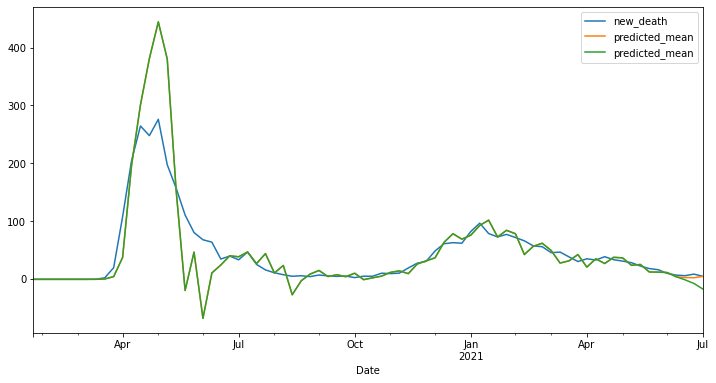

In [36]:
sari_week_predict = sari_week.predict(dynamic = False,
#                            typ = 'levels',
                            exog = test_df_week[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']]
)
sari_week_test_predict = sari_week.predict(dynamic = len(test_df_week)-4,
                                 exog = test_df_week[['Admin_Per_100K', 'Administered_Dose1_Pop_Pct']]
)

ax = test_df_week['new_death'].plot(legend=True,figsize=(12,6))
sari_week_predict.plot(legend=True)
sari_week_test_predict.plot(legend=True)
ax.autoscale(axis='x', tight=True);

In [37]:
proph_test_df = test_df.copy().resample('W').mean()
proph_test_df.reset_index(inplace = True)
proph_test_df.rename(columns = {'Date': 'ds',
                                'new_death': 'y'},
                     inplace = True)
proph_test_df

,ds,Distributed,Dist_Per_100K,Administered,Admin_Per_100K,Administered_Dose1_Pop_Pct,y
0,2020-01-26,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,2020-02-02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
2,2020-02-09,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
3,2020-02-16,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
4,2020-02-23,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
5,2020-03-01,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
6,2020-03-08,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000
7,2020-03-15,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.285714
8,2020-03-22,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,2.571429
9,2020-03-29,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,20.142857


In [38]:
m = Prophet(n_changepoints = 30,
            seasonality_mode = 'multiplicative',
            changepoint_prior_scale = 3)
m.add_regressor('Administered_Dose1_Pop_Pct')

m.fit(proph_test_df[['ds', 'y', 'Administered_Dose1_Pop_Pct']][:65])

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


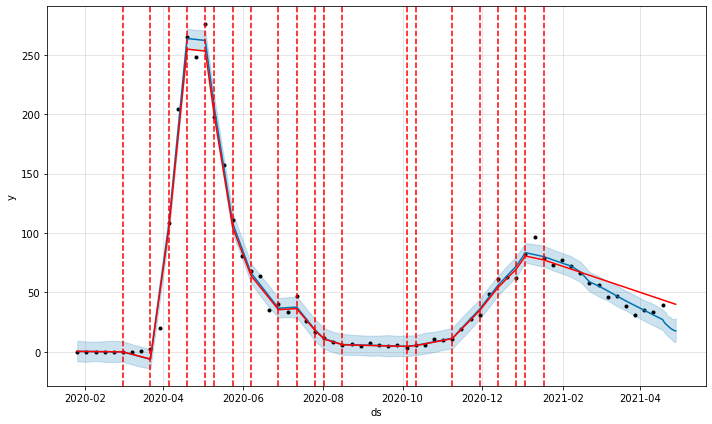

In [39]:
future = m.make_future_dataframe(periods=10)
future['Administered_Dose1_Pop_Pct'] = proph_test_df['Administered_Dose1_Pop_Pct']
forecast = m.predict(future)

future2 = m.make_future_dataframe(periods=10)
future2['Administered_Dose1_Pop_Pct'] = proph_test_df['Administered_Dose1_Pop_Pct']*.05
forecast2 = m.predict(future2)

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast);

In [ ]:
#(forecast['yhat'] == forecast2['yhat']).value_counts()

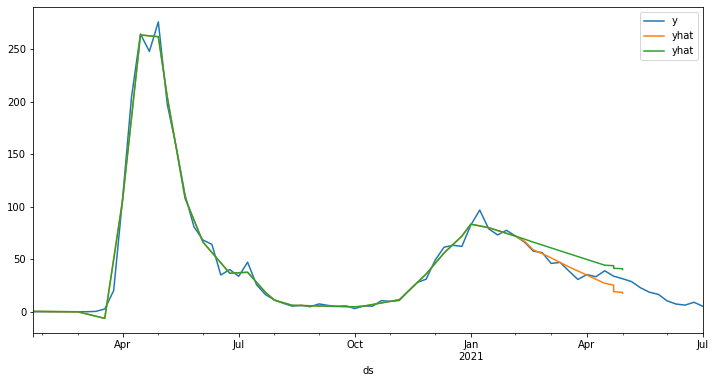

In [40]:
ax = proph_test_df.plot(x = 'ds', y = 'y', legend=True, figsize=(12,6))
forecast.plot(x = 'ds', y = 'yhat', ax = ax, legend=True)
forecast2.plot(x = 'ds', y = 'yhat', ax = ax, legend=True);

In [ ]:
def predictions(model, column, dataframe, multiplier):
    future = model.make_future_dataframe(periods = 5)
    future[column] = dataframe[column] * multiplier
    forecast = model.predict(future)
    return forecast['ds'], forecast['yhat']

In [ ]:
import plotly.graph_objects as go
# Create figure
fig = go.Figure()

# Add traces, one for each slider step
for step in np.arange(0, 2, 0.1):
    x, y = predictions(m, 'Administered_Dose1_Pop_Pct', proph_test_df, step)
    fig.add_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=6),
#            name="𝜈 = " + str(step),
            x=x,
            y=y))

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(len(fig.data)):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Vaccine Rate Multipler at: " + str(i/10)}],
    )
    step["args"][0]["visible"][i] = True
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Vaccination Rate Multiplier: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

fig.show()

In [ ]:
m.plot_components(forecast);

In [ ]:
rnn_test_df = test_df.copy()
#rnn_test_df.reset_index(inplace = True)

rnn_train = df.iloc[:450]
rnn_test = df.iloc[450:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(rnn_train)

scaled_train = scaler.transform(rnn_train)
scaled_test = scaler.transform(rnn_test)

In [ ]:
rnn_test_df

In [ ]:
import pyodata
import requests

In [ ]:
url = 'https://data.cdc.gov/resource/unsk-b7fc.json'
data = requests.get(url).json()

In [ ]:
df = pd.DataFrame(data)
df